In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from PIL import Image
from skimage import measure
from skimage.metrics import structural_similarity as ssim
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import matplotlib.pyplot as plt
from utils.perimetric_complexity import perimetricComplexity
from utils.complexity_metrics import calculate_stroke_count, pixel_count_complexity, apply_distance_transform, num_components
from utils.unicode_utils import *
from utils.calculate_perimeter_lengths import calculate_perimeter_lengths
from utils.complexity_metrics import *

In [61]:
smiles_file_path = '/Users/tiananoll-walker/Documents/bmsis/alphabets_code/alphabet_complexity-main/alphabet_complexity/Coded_AAs.txt'
with open(smiles_file_path, 'r') as f:
    lines = f.readlines()

smiles_aas_path = '/Users/tiananoll-walker/Documents/bmsis/alphabets_code/alphabet_complexity-main/alphabet_complexity/data/SMILESforAAs.txt'
with open(smiles_aas_path, 'r') as f:
    smiles_aas = [line.strip() for line in f.readlines()]

amino_acid_prevalence = {
    'Alanine': 0.074,
    'Arginine': 0.042,
    'Asparagine': 0.044,
    'Aspartic_acid': 0.059,
    'Cysteine': 0.033,
    'Glutamic_acid': 0.058,
    'Glutamine': 0.037,
    'Glycine': 0.074,
    'Histidine': 0.029,
    'Isoleucine': 0.038,
    'Leucine': 0.076,
    'Lysine': 0.072,
    'Methionine': 0.018,
    'Phenylalanine': 0.040,
    'Proline': 0.050,
    'Serine': 0.081,
    'Threonine': 0.062,
    'Tryptophan': 0.013,
    'Tyrosine': 0.033,
    'Valine': 0.068
}    

def calculate_perimeter_lengths(picture, threshold=0.001):
    picture_pil = Image.fromarray(picture)
    gray_image = picture_pil.convert('L')
    picture_np = np.array(gray_image)
    binarized_image = (picture_np > threshold).astype(np.uint8) * 255
    contours = measure.find_contours(binarized_image, 0.5)
    stroke_lengths = [len(contour) for contour in contours]
    return stroke_lengths

def generate_molecule_image(molecule):
    mol_block = Chem.MolToMolBlock(molecule)
    image = Draw.MolToImage(molecule, size=(300, 300))
    return image


smiles = []  
is_biological = []
names = []
aa_prevalence = []

for line in lines:
    parts = line.strip().split(',')
    if len(parts) >= 2:
        name = parts[0].strip() 
        smiles_str = parts[1].strip()  
    
        if name in amino_acid_prevalence:  
            is_bio = True
            prevalence = amino_acid_prevalence[name]
        else:
            is_bio = False
            prevalence = None
    
        names.append(name)
        smiles.append(smiles_str)
        aa_prevalence.append(prevalence)
        is_biological.append(is_bio)

for smiles_str in smiles_aas:
    smiles.append(smiles_str)
    is_biological.append(False)
    names.append(None) 
    aa_prevalence.append(None)


data = {'Name':names,'SMILES': smiles, 'Is_Biological': is_biological, 'Prevalence': aa_prevalence}
df_molecules = pd.DataFrame(data)


perimetric_complexities = []
compression_sizes = []
pixel_counts = []
num_components_list = []
distance_transform_means = []
distance_transform_stds = []
perimeter_lengths = []
num_perimeters = []
symmetry_horizontal_values = []
symmetry_vertical_values = []

def rowtobin(row):
    white = [255,255,255]
    return [1 - int(np.array_equiv(x, white)) for x in row]

def complexity(imarr):
    perimetric_complexity = perimetricComplexity(imarr)
    pixel_count = pixel_count_complexity(imarr)
    num_components_value = num_components(imarr)
    distance_transform = apply_distance_transform(imarr)
    distance_transform_mean = np.mean(distance_transform)
    distance_transform_std = np.std(distance_transform)
    stroke_lengths = calculate_perimeter_lengths(imarr)
    check_symm_h = check_symmetry_nw(imarr, type = "h")
    check_symm_v = check_symmetry_nw(imarr, type = "v")
    
    return np.array([perimetric_complexity, pixel_count, num_components_value, distance_transform_mean, distance_transform_std, check_symm_h, check_symm_v])

for smiles_str in df_molecules['SMILES']:
    molecule = Chem.MolFromSmiles(smiles_str)
    image = generate_molecule_image(molecule)
    img_data = np.array(image)

    bw_image = np.array([rowtobin(row) for row in img_data])
    bw_image = bw_image.astype(np.uint8)

    complexity_metrics = complexity(bw_image)

    perimetric_complexity = complexity_metrics[0]
    pixel_count = complexity_metrics[1]
    num_components_value = complexity_metrics[2]
    distance_transform_mean = complexity_metrics[3]
    distance_transform_std = complexity_metrics[4]
    check_symm_h = complexity_metrics[5]
    check_symm_v = complexity_metrics[6]

    stroke_lengths = calculate_perimeter_lengths(img_data)

    
    perimetric_complexities.append(perimetric_complexity)
    pixel_counts.append(pixel_count)
    num_components_list.append(num_components_value)
    distance_transform_means.append(distance_transform_mean)
    distance_transform_stds.append(distance_transform_std)
    perimeter_lengths.append(stroke_lengths)
    num_perimeters.append(len(stroke_lengths))
    symmetry_horizontal_values.append(check_symm_h)
    symmetry_vertical_values.append(check_symm_h)

df_molecules['Perimetric_Complexity'] = perimetric_complexities
df_molecules['Pixel_Count'] = pixel_counts
df_molecules['Num_Components'] = num_components_list
df_molecules['Distance_Transform_Mean'] = distance_transform_means
df_molecules['Distance_Transform_Std'] = distance_transform_stds
df_molecules['Perimeter_Length'] = perimeter_lengths
df_molecules['Num_Perimeters'] = num_perimeters
df_molecules['Symmetry_Horizontal'] = symmetry_horizontal_values
df_molecules['Symmetry_Vertical'] = symmetry_vertical_values

print(df_molecules)

excel_file_path = 'molecules_data_rdkit.xlsx'
df_molecules.to_excel(excel_file_path, index=False, float_format='%.3f')


           Name           SMILES  Is_Biological  Prevalence  \
0       Alanine      CC(N)C(=O)O           True       0.074   
1        Serine     NC(CO)C(=O)O           True       0.081   
2       Proline    O=C(O)C1CCCN1           True       0.050   
3        Valine  CC(C)C(N)C(=O)O           True       0.068   
4     Threonine  CC(O)C(N)C(=O)O           True       0.062   
...         ...              ...            ...         ...   
1928       None     C=CCNCC(=O)O          False         NaN   
1929       None    O=C(O)C1CCCN1          False         NaN   
1930       None   O=C(O)C1C=CCN1          False         NaN   
1931       None   O=C(O)C1CC=CN1          False         NaN   
1932       None        CNCC(=O)O          False         NaN   

      Perimetric_Complexity  Pixel_Count  Num_Components  \
0                  2.230795     0.035422             3.0   
1                  1.616655     0.028656             4.0   
2                  2.534357     0.036300             3.0   
3  

Perimetric_Complexity      float64
Pixel_Count                float64
Num_Components             float64
Distance_Transform_Mean    float64
Distance_Transform_Std     float64
Perimeter_Length           float64
Num_Perimeters               int64
Symmetry_Horizontal        float64
Symmetry_Vertical          float64
Prevalence                 float64
dtype: object
Perimetric_Complexity         0
Pixel_Count                   0
Num_Components                0
Distance_Transform_Mean       0
Distance_Transform_Std        0
Perimeter_Length           1933
Num_Perimeters                0
Symmetry_Horizontal           0
Symmetry_Vertical             0
Prevalence                 1913
dtype: int64


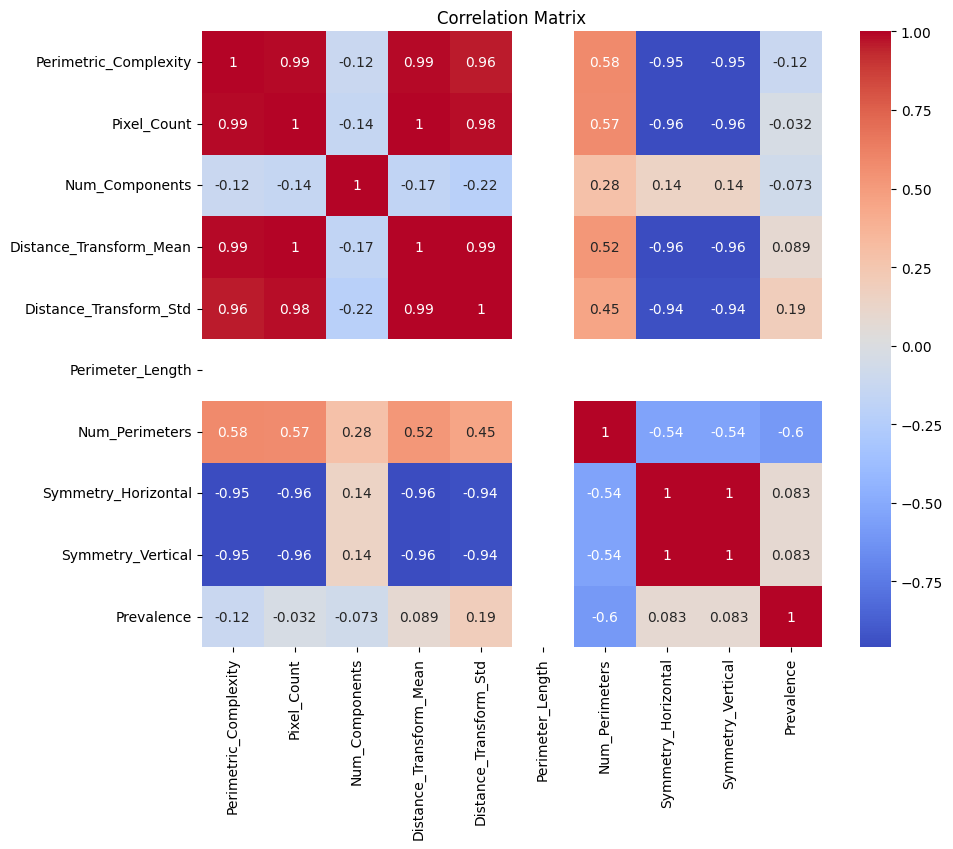

ValueError: array must not contain infs or NaNs

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


complexity_metrics = ['Perimetric_Complexity', 'Pixel_Count', 'Num_Components',
                      'Distance_Transform_Mean', 'Distance_Transform_Std',
                      'Perimeter_Length', 'Num_Perimeters', 'Symmetry_Horizontal', 'Symmetry_Vertical']

print(df_molecules[complexity_metrics + ['Prevalence']].dtypes)
print(df_molecules[complexity_metrics + ['Prevalence']].isnull().sum())

df_molecules['Prevalence'] = df_molecules['Prevalence'].astype(float)

df_molecules['Perimeter_Length'] = pd.to_numeric(df_molecules['Perimeter_Length'], errors='coerce')
df_molecules['Perimeter_Length'] = df_molecules['Perimeter_Length'].astype(float)

correlation_matrix = df_molecules[complexity_metrics + ['Prevalence']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

for complexity_metric in complexity_metrics:
    corr_coeff, p_value = pearsonr(df_molecules['Prevalence'], df_molecules[complexity_metric])
    print(f"Correlation coefficient ({complexity_metric}): {corr_coeff:.4f}")
    print(f"P-value ({complexity_metric}): {p_value:.4e}")


In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

dfu = pd.read_csv('data/dfu_v3_lite.csv')

dfmpath = 'data/dfm_v2.pkl'
if os.path.exists(dfmpath):
    dfm = pd.read_pickle(dfmpath)
else:
    from utils.molecular_utils import make_pic, aa_smiles
    from utils.script_complexity import add_script_complexity_cols
    dfm = pd.read_csv('data/AACLBR descriptors with SMILES.csv')
    
    dfm['picture'] = dfm.Smiles.apply(make_pic)
    dfm['script'] = 'molecule'
    dfm['is_biotic'] = dfm.Smiles.isin(aa_smiles)

    dfm = add_script_complexity_cols(dfm)
    dfm.to_pickle(dfmpath)

cols_u = [c for c in dfu.columns 
    if dfu[c].dtype in ['int64','float64']
    and c!='complexity']

pipe_u = make_pipeline(StandardScaler(), PCA(1))
dfu['complexity'] = pipe_u.fit_transform(np.array(dfu[cols_u]))[:,0]

cols_m = [c for c in dfm.columns[2:] 
          if np.mean(dfm[c].isna()) < 0.1
          and dfm[c].dtype in ['int64', 'float64'] 
          and c not in cols_u]

pipe_m = make_pipeline(StandardScaler(), PCA(1))
m_complexity = pipe_m.fit_transform(np.array(dfm[cols_m].fillna(0)))[:,0]

u_complexity = pipe_u.transform(np.array(dfm[cols_u]))[:,0]

#print(u_complexity, len(u_complexity))
#print(m_complexity, len(m_complexity))

u_complexity [-3.73812453 -1.52174554 -2.40254744 ... -0.87024141 -0.94616366
 -3.5945256 ] 1913
m_complexity [73.76358804 27.93279255 28.35357234 ... 40.94306878 41.41524333
 59.69323569] 1913


In [52]:

complexity_metrics_molecules = ['perimetric_complexity', 'pixel_count', 'num_components',
                                'distance_transform_mean', 'distance_transform_std',
                                'perimeter_len', 'num_perimeters', 'horizontal_symmetry', 'vertical_symmetry']


dfu_subset = dfu.iloc[:len(u_complexity)]

for complexity_metric in complexity_metrics_molecules:
    corr_coeff_u, p_value_u = pearsonr(u_complexity, dfm[complexity_metric])
    corr_coeff_m, p_value_m = pearsonr(m_complexity, dfm[complexity_metric])
    print(f"Correlation coefficient (u_complexity, {complexity_metric}): {corr_coeff_u:.4f}")
    print(f"P-value (u_complexity, {complexity_metric}): {p_value_u:.4e}")
    print(f"Correlation coefficient (m_complexity, {complexity_metric}): {corr_coeff_m:.4f}")
    print(f"P-value (m_complexity, {complexity_metric}): {p_value_m:.4e}")



Correlation coefficient (u_complexity, perimetric_complexity): 0.7984
P-value (u_complexity, perimetric_complexity): 0.0000e+00
Correlation coefficient (m_complexity, perimetric_complexity): -0.8747
P-value (m_complexity, perimetric_complexity): 0.0000e+00
Correlation coefficient (u_complexity, pixel_count): -0.4437
P-value (u_complexity, pixel_count): 4.2080e-93
Correlation coefficient (m_complexity, pixel_count): -0.3599
P-value (m_complexity, pixel_count): 1.3933e-59
Correlation coefficient (u_complexity, num_components): 0.6506
P-value (u_complexity, num_components): 1.0396e-230
Correlation coefficient (m_complexity, num_components): -0.8523
P-value (m_complexity, num_components): 0.0000e+00
Correlation coefficient (u_complexity, distance_transform_mean): -0.8177
P-value (u_complexity, distance_transform_mean): 0.0000e+00
Correlation coefficient (m_complexity, distance_transform_mean): 0.0793
P-value (m_complexity, distance_transform_mean): 5.1492e-04
Correlation coefficient (u_com

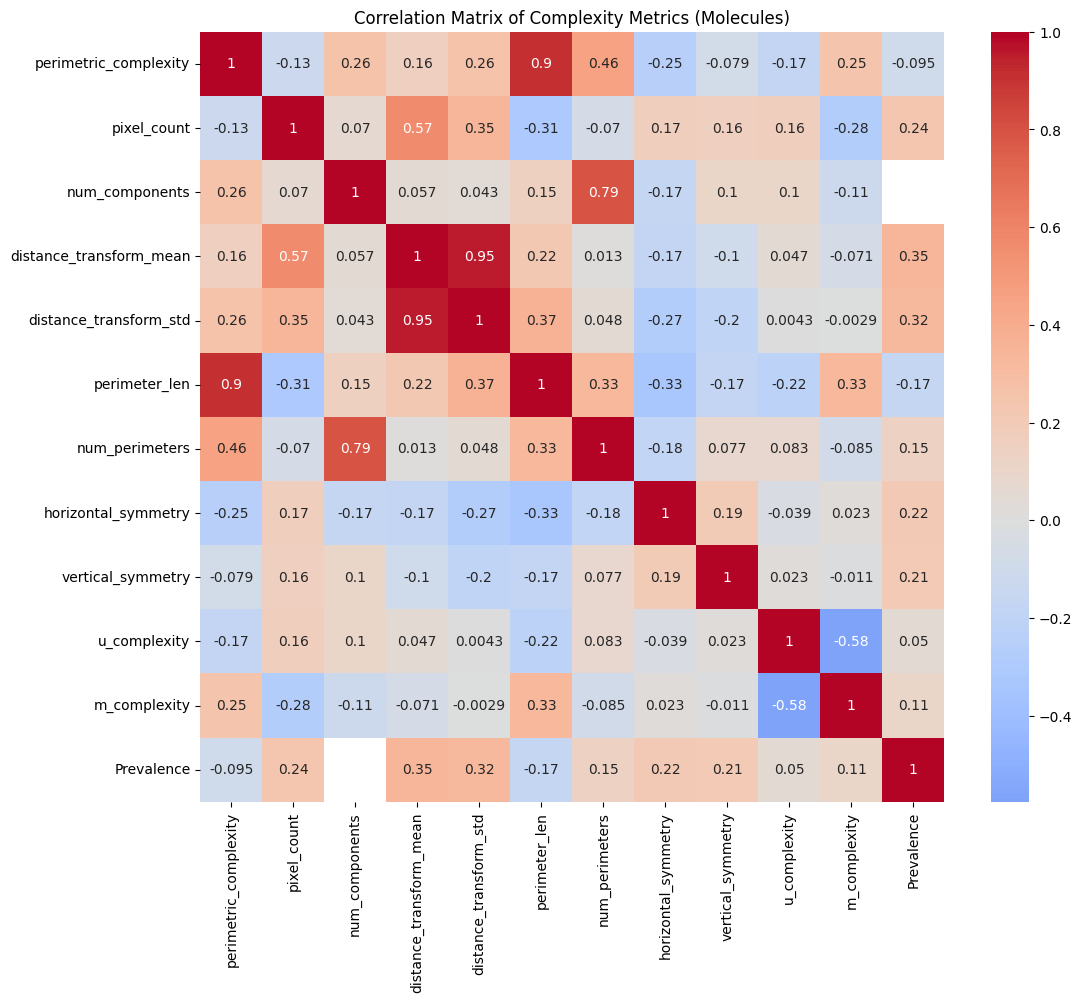

In [54]:
complexity_metrics_molecules = ['perimetric_complexity', 'pixel_count', 'num_components',
                                'distance_transform_mean', 'distance_transform_std',
                                'perimeter_len', 'num_perimeters', 'horizontal_symmetry', 'vertical_symmetry']

dfu_subset = dfu.iloc[:len(u_complexity)]

metrics_data = dfu_subset[complexity_metrics_molecules].copy()
metrics_data['u_complexity'] = u_complexity
metrics_data['m_complexity'] = m_complexity

#align Prevalence with u_complexity and m_complexity
prevalence_data = df_molecules[df_molecules['Is_Biological']].copy()
prevalence_data = prevalence_data.loc[:len(u_complexity)-1, ['Prevalence']]

correlation_matrix = pd.concat([metrics_data, prevalence_data], axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Complexity Metrics (Molecules)')
plt.show()
